In [145]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [146]:
table = pd.read_table('../drug-discovery/1663769555_8559356_train.txt', names=['binding','sequence'])

In [147]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame):
    count_vectorizer = CountVectorizer(binary=True)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed


In [148]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form_with_vocab(data_frame, vocab):
    count_vectorizer = CountVectorizer(binary=True, vocabulary=vocab)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [149]:
from sklearn.feature_selection import SelectKBest, chi2
def select_k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [150]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size=.65)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.70)

In [151]:
active_train_df = pd.DataFrame(active_train)
active_test_df = pd.DataFrame(active_test)
active_binding_train_df = pd.DataFrame(active_binding_train)
active_binding_test_df = pd.DataFrame(active_binding_test)

active_train_df['binding'] = active_binding_train_df['binding']
active_test_df['binding'] = active_binding_test_df['binding']

In [152]:
not_active_train_df = pd.DataFrame(not_active_train)
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_train_df = pd.DataFrame(not_active_binding_train)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)

not_active_train_df['binding'] = not_active_binding_train_df['binding']
not_active_test_df['binding'] = not_active_binding_test_df['binding']

In [153]:
train_df = pd.concat([active_train_df,not_active_train_df]).reset_index()
train_df = train_df.drop('index',axis=1)
print(train_df.binding.value_counts())

test_df = pd.concat([active_test_df,not_active_test_df]).reset_index()
test_df = test_df.drop('index',axis=1)
print(test_df.binding.value_counts())

0    505
1     50
Name: binding, dtype: int64
0    217
1     28
Name: binding, dtype: int64


In [154]:
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler()
x_sampled, y_sampled = sampler.fit_resample(np.array(train_df.sequence).reshape(-1,1),train_df.binding)
x_test_sampled, y_test_sampled = sampler.fit_resample(np.array(test_df.sequence).reshape(-1,1),test_df.binding)

In [155]:
final_train_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_train_set['binding'] = y_sampled
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(x_test_sampled, columns  =["sequence"])
final_test_set['binding'] = y_test_sampled
print(final_test_set.binding.value_counts())

1    505
0    505
Name: binding, dtype: int64
1    217
0    217
Name: binding, dtype: int64


In [156]:
vectorizer_global, training_features = return_binary_vectorized_form(final_train_set.sequence)
k_best_feature = select_k_best_features(training_features, final_train_set.binding, 0.15, vectorizer_global.get_feature_names_out())
vectorizer_k_best, training_split = return_binary_vectorized_form_with_vocab(final_train_set.sequence,k_best_feature)
test_split = vectorizer_k_best.transform(final_test_set.sequence).toarray()

In [157]:
print(training_split.shape)
print(test_split.shape)

(1010, 12069)
(434, 12069)


In [158]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)
print(train_result.shape)
print(test_result.shape)

(1010,)
(434,)


In [159]:
test_result.sum()

217

In [160]:
train_result.sum()

505

In [161]:
training_split.shape[-1]

12069

In [170]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(training_split.shape[-1],)),
    # tf.keras.layers.Dropout(0.85),
    tf.keras.layers.Dense(2,activation='relu',kernel_regularizer=tf.keras.regularizers.L1(.1)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [171]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=METRICS)

In [172]:
num_epochs = 20
history = model.fit(training_split, train_result, epochs=num_epochs, validation_data=(test_split, test_result))

Epoch 1/20


/Users/bhabaranjanpanigrahi/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2022-10-06 15:06:42.512910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 8.9283 - tp: 380.0000 - fp: 211.0000 - tn: 294.0000 - fn: 125.0000 - accuracy: 0.6673 - precision: 0.6430 - recall: 0.7525 - auc: 0.6736 - prc: 0.6619

2022-10-06 15:06:43.816799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 55ms/step - loss: 8.9283 - tp: 380.0000 - fp: 211.0000 - tn: 294.0000 - fn: 125.0000 - accuracy: 0.6673 - precision: 0.6430 - recall: 0.7525 - auc: 0.6736 - prc: 0.6619 - val_loss: 2.1190 - val_tp: 170.0000 - val_fp: 43.0000 - val_tn: 174.0000 - val_fn: 47.0000 - val_accuracy: 0.7926 - val_precision: 0.7981 - val_recall: 0.7834 - val_auc: 0.8056 - val_prc: 0.8404
Epoch 2/20
32/32 [==============================] - 1s 19ms/step - loss: 1.4183 - tp: 375.0000 - fp: 20.0000 - tn: 485.0000 - fn: 130.0000 - accuracy: 0.8515 - precision: 0.9494 - recall: 0.7426 - auc: 0.7603 - prc: 0.8036 - val_loss: 1.0728 - val_tp: 31.0000 - val_fp: 3.0000 - val_tn: 214.0000 - val_fn: 186.0000 - val_accuracy: 0.5645 - val_precision: 0.9118 - val_recall: 0.1429 - val_auc: 0.5494 - val_prc: 0.5653
Epoch 3/20
32/32 [==============================] - 1s 18ms/step - loss: 1.0255 - tp: 255.0000 - fp: 3.0000 - tn: 502.0000 - fn: 250.0000 - accuracy: 0.7495 - precision: 0

In [2274]:
table_test = pd.read_table('../drug-discovery/1663769555_8653905_test.txt', names=['sequence'])

In [2275]:
unlabeled_test_sequence = vectorizer_k_best.transform(table_test.sequence).toarray()

In [2276]:
unlabeled_test_sequence.shape

(350, 12325)

In [2277]:
y = model.predict(unlabeled_test_sequence)

 8/11 [====================>.........] - ETA: 0s

2022-10-06 02:44:38.336909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 15ms/step


In [2278]:
y

array([[0.6592826 ],
       [0.23935299],
       [0.296676  ],
       [0.3219071 ],
       [0.32281226],
       [0.3201064 ],
       [0.33405152],
       [0.36273706],
       [0.35569504],
       [0.49149922],
       [0.25525194],
       [0.3375533 ],
       [0.20907633],
       [0.33114335],
       [0.35033846],
       [0.46227854],
       [0.15608594],
       [0.23246264],
       [0.27420235],
       [0.24557185],
       [0.19583343],
       [0.3490965 ],
       [0.12967853],
       [0.24576283],
       [0.39984587],
       [0.75503534],
       [0.33622605],
       [0.2689    ],
       [0.32833603],
       [0.26585162],
       [0.3009542 ],
       [0.37062418],
       [0.31932494],
       [0.17161638],
       [0.2921615 ],
       [0.28504017],
       [0.28737098],
       [0.34804067],
       [0.43381003],
       [0.34715256],
       [0.26454854],
       [0.29872432],
       [0.28909793],
       [0.22936128],
       [0.19502898],
       [0.26172948],
       [0.29550877],
       [0.296

In [2279]:
# for i in range(3):
z = [1 if i>=.5 else 0 for i in y ]

In [2283]:
z[61]

1

In [2284]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], z))
outfile.close()

/var/folders/w9/17dx1py559xc12bhjgp9w4_80000gn/T/ipykernel_22595/2300480017.py:16: RuntimeWarning: invalid value encountered in divide
  k = (2 * test_precission * test_recall )/ (test_precission+test_recall)


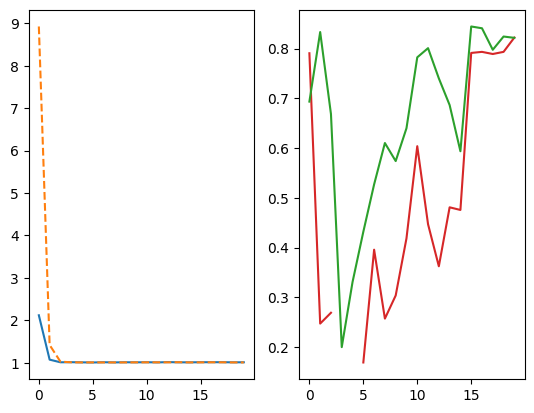

In [173]:
fig, (ax1,ax2) = plt.subplots(1,2)
testloss = np.array(history.history['val_loss']).reshape(len(history.history['val_loss']),1)
trainloss = np.array(history.history['loss']).reshape(len(history.history['loss']),1)

ax1.plot(history.epoch, testloss, '-')
ax1.plot(history.epoch, trainloss, '--')
# ax1.ylabel('loss')
# ax1.xlabel('epoch')

train_precision = np.array(history.history['precision']).reshape(len(history.history['loss']),1)
train_recall= np.array(history.history['recall']).reshape(len(history.history['loss']),1)
j =( 2 * train_precision * train_recall) / (train_precision+train_recall)

test_precission = np.array(history.history['val_precision']).reshape(len(history.history['loss']),1)
test_recall = np.array(history.history['val_recall']).reshape(len(history.history['loss']),1)
k = (2 * test_precission * test_recall )/ (test_precission+test_recall)
# plt.plot(history.epoch,j, '-')
# plt.plot(k,'--')

ax2.plot(history.epoch, k, 'tab:red')
ax2.plot(history.epoch, j, 'tab:green')

# ax3.plot(j+3)
# ax3.plot(trainloss,'tab:blue')